# DTW for Midi-Audio Alignment

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from scripts.midi.MidiLoader import MidiLoader
from scripts.midi.MidiSynth import MidiSynth
from scripts.midi.MidiPlayer import MidiPlayer
from scripts.audio.AudioPlayer import AudioPlayer

from scripts.dtw.MidiDTW import MidiDTW, CQTFeatures

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



### Step 0: Listen to the query (MIDI) vs. the template (ME)

Our goal is to warp the MIDI note lengths to match the user's recorded audio note lengths so we can easily compare pitches just by jumping to a point in the midifile.

In [3]:
# To inspect how MIDI file is currently parsed
message_dict, program_dict, pitch_df = MidiLoader.parse_midi('data/midi_files/fast_fugue_midi.mid')

# Initialize a MidiSynth + MidiPlayer with a given soundfont
SOUNDFONT = 'data/MuseScore_General.sf3'
midi_synth = MidiSynth(soundfont_path=SOUNDFONT)
midi_player = MidiPlayer(midi_synth)

# Play a given midi file
MIDI_FILEPATH = 'data/midi_files/fast_fugue_midi.mid'
midi_player.load_midi(MIDI_FILEPATH)
midi_player.play(start_time=0)

In [4]:
# Play the template audio
audio_player = AudioPlayer()

# Play a given audio file
AUDIO_FILEPATH = 'data/audio_files/fugue_recording.mp3'
audio_player.load_audio(AUDIO_FILEPATH)
audio_player.play()

## Step 1: Load audio data

MIDI and audio can be compared with DTW by converting both into intermediary representation. 

This is commonly done through synthesizing MIDI to get audio signals and comparing a common spectral transform of the audio file and the synthesized MIDI audio.

In [5]:
SOUNDFONT = 'data/MuseScore_General.sf3'
MIDI_FILEPATH = 'data/midi_files/fast_fugue_midi.mid'
AUDIO_FILEPATH = 'data/audio_files/fugue_recording.mp3'

MidiDTW.update_soundfont(SOUNDFONT)
midi_audio = MidiDTW.midi_to_audio(MIDI_FILEPATH)
user_audio = MidiDTW.load_audio(AUDIO_FILEPATH)

## Step 2: Compute the CQT of audio data

CQT, or Constant-Q transform, represents the amount of energy in logarithmically spaced bins

Raffel, Ellis 2016 uses a constant-Q spectra spanning 4 octaves starting from MIDI note C2 (65.4 Hz) with 12 bins / octave.

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def display_cqt(cqt):
    """ Plot a CQT with sane defaults """
    plt.imshow(cqt.T, aspect='auto', interpolation='nearest',
               origin='lower', cmap=plt.cm.hot,
               vmin=np.percentile(cqt, 5), vmax=np.percentile(cqt, 95))
    plt.xlabel('Frame')
    plt.ylabel('Frequency bin')

In [6]:
midi_cqt =  MidiDTW.extract_cqt(midi_audio)
user_cqt = MidiDTW.extract_cqt(user_audio)

/Users/sarah/Desktop/shasha/midi-dtw/scripts/dtw/MidiDTW.py:120: ComplexWarning: Casting complex values to real discards the imaginary part
  cqt = cqt.astype(np.float32) # Store CQT as float32 to save space/memory


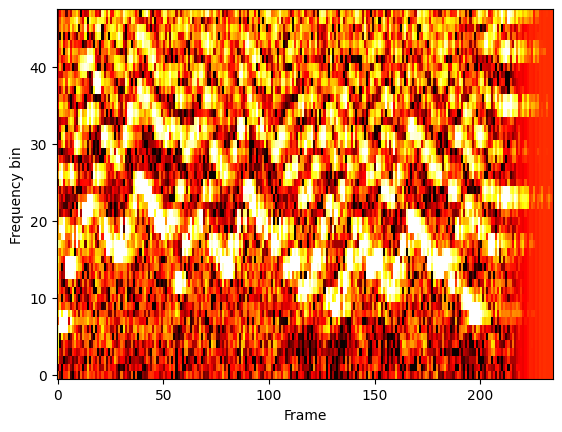

In [16]:
display_cqt(midi_cqt.cqt)

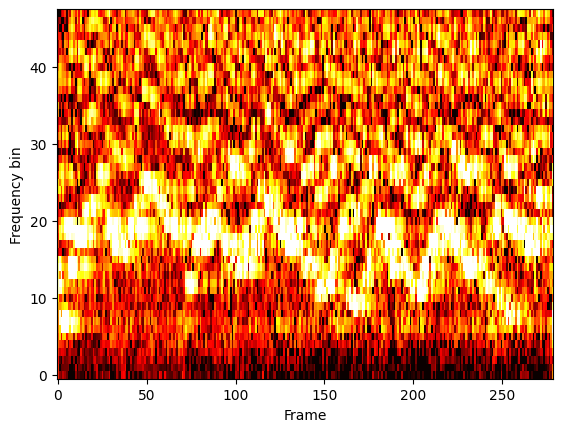

In [17]:
display_cqt(user_cqt.cqt)

## Step 3: Perform the DTW algorithm

#### Current Parameters
- distance_metric = 'cosine'
- step_pattern = symmetric1 (maybe try symmetric2?)
- window_type = 'sakoechiba'
- window_size' = 80 (still tuning)
   
    -> normalize midi tempo using midi and audio duration

In [7]:
# Perform the DTW algorithm
midi_cqt, user_cqt = MidiDTW.midi_dtw(midi_cqt, user_cqt)

DTW alignment computed.
Distance: 11.175927418953414
Mean alignment error: 31.506802721088434


## Step 4: Create an aligned MIDI

Contains the pitches / velocities of the original MIDI file but with the note onset times / durations of the user's audio to enable pitch correction.

In [8]:
message_dict, program_dict, pitch_df = MidiLoader.parse_midi(MIDI_FILEPATH)
aligned_midi = MidiDTW.align_midi(midi_cqt, user_cqt, pitch_df)

ALIGNED_MIDI_FILEPATH = MIDI_FILEPATH.replace('.mid', '_aligned.mid')
aligned_midi.write(ALIGNED_MIDI_FILEPATH)

In [9]:
aligned_message_dict, aligned_program_dict, aligned_pitch_df = MidiLoader.parse_midi(ALIGNED_MIDI_FILEPATH)

aligned_pitch_df

,start,channel,pitch,velocity,duration
0,0.000000,0,62,100,0.229545
1,0.231818,0,69,100,0.138636
2,0.370455,0,73,100,0.277273
3,0.650000,0,76,100,0.138636
4,0.788636,0,77,100,0.138636
...,...,...,...,...,...
60,11.518182,0,63,100,0.320455
61,11.843182,0,74,100,0.136364
62,11.981818,0,79,100,0.184091
63,12.168182,0,72,100,0.184091


## Listen to the aligned MIDI!

In [ ]:
import librosa
import sounddevice as sd
from time import sleep

FS_SAMPLE_RATE = 22050
AUDIO_FILEPATH = 'data/audio_files/fugue_recording.mp3'
ALIGNED_MIDI_FILEPATH = 'data/midi_files/fast_fugue_midi_aligned.mid'

# aligned_message_dict, aligned_program_dict, aligned_pitch_df = MidiLoader.parse_midi(ALIGNED_MIDI_FILEPATH)

def play_sync_midi(audio_filepath, aligned_midi_filepath, sample_rate=22050):
    # Load the MP3 file
    user_audio, user_sample_rate = librosa.load(audio_filepath, sr=sample_rate)

    # Load the aligned MIDI file
    aligned_message_dict, aligned_program_dict, aligned_pitch_df = MidiLoader.parse_midi(aligned_midi_filepath)

    for row_index, note in aligned_pitch_df.iterrows():
        user_start_idx = int(note.start * user_sample_rate)
        user_end_idx = int((note.start + note.duration) * user_sample_rate)

        audio_slice = user_audio[user_start_idx:user_end_idx]
        sd.play(audio_slice, user_sample_rate)
        sd.wait()

        sleep(.5)

play_sync_midi(AUDIO_FILEPATH, ALIGNED_MIDI_FILEPATH, FS_SAMPLE_RATE)

In [12]:
# Initialize a MidiSynth + MidiPlayer with a given soundfont
SOUNDFONT = 'data/MuseScore_General.sf3'
midi_synth = MidiSynth(soundfont_path=SOUNDFONT)
midi_player = MidiPlayer(midi_synth)

# Play a given midi file
# MIDI_FILEPATH = 'data/midi_files/fast_fugue_midi.mid'

midi_player.load_midi(ALIGNED_MIDI_FILEPATH)
midi_player.play(start_time=0)

## Summarized DTW Flow
Try out some different parameters

In [4]:
SOUNDFONT = 'data/MuseScore_General.sf3'
MIDI_FILEPATH = 'data/midi_files/fugue_midi.mid'
AUDIO_FILEPATH = 'data/audio_files/user_fugue2.mp3'

MidiDTW.update_soundfont(SOUNDFONT)
midi_audio = MidiDTW.midi_to_audio(MIDI_FILEPATH)
user_audio = MidiDTW.load_audio(AUDIO_FILEPATH)

midi_cqt =  MidiDTW.extract_cqt(midi_audio)
user_cqt = MidiDTW.extract_cqt(user_audio)

midi_cqt, user_cqt = MidiDTW.midi_dtw(midi_cqt, user_cqt)

message_dict, program_dict, pitch_df = MidiLoader.parse_midi(MIDI_FILEPATH)
aligned_midi = MidiDTW.align_midi(midi_cqt, user_cqt, pitch_df)

ALIGNED_MIDI_FILEPATH = MIDI_FILEPATH.replace('.mid', '_aligned2.mid')
aligned_midi.write(ALIGNED_MIDI_FILEPATH)

DTW alignment computed.
Distance: 15.85472469092833
Mean alignment error: 6.877483443708609


/Users/sarah/Desktop/shasha/MIDI-templater/notebooks/scripts/dtw/MidiDTW.py:120: ComplexWarning: Casting complex values to real discards the imaginary part
  cqt = cqt.astype(np.float32) # Store CQT as float32 to save space/memory


In [6]:
# Initialize a MidiSynth + MidiPlayer with a given soundfont
# if not midi_synth or midi_player:
midi_synth = MidiSynth(soundfont_path=SOUNDFONT)
midi_player = MidiPlayer(midi_synth)

# Play the aligned midi file
midi_player.load_midi(ALIGNED_MIDI_FILEPATH)
midi_player.play(start_time=0)

## Convert MIDI to audio

In [3]:
import pretty_midi
import numpy as np
import librosa
import soundfile as sf

# Define the sample rate and path to your soundfont
FS_SAMPLE_RATE = 22050
SOUNDFONT = "data/MuseScore_General.sf3"
MIDI_FILEPATH = 'data/midi_files/fugue_midi.mid'
OUTPUT_FILEPATH = MIDI_FILEPATH.replace('.mid', '.wav')

# Load the MIDI file
midi_data = pretty_midi.PrettyMIDI(MIDI_FILEPATH)

# Synthesize the audio using fluidsynth
audio_data = midi_data.fluidsynth(fs=FS_SAMPLE_RATE, sf2_path=SOUNDFONT)

# Normalize the audio
audio_data = librosa.util.normalize(audio_data)

# Save the audio to a file
sf.write(OUTPUT_FILEPATH, audio_data, FS_SAMPLE_RATE)

print(f"Audio saved to {OUTPUT_FILEPATH}")

Audio saved to data/midi_files/fugue_midi.wav
